Train an SVM classifier on the MNIST dataset. Since SVM classifiers are binary
classifiers, you will need to use one-versus-the-rest to classify all 10 digits. You
may want to tune the hyperparameters using small validation sets to speed up the
process. What accuracy can you reach?

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
mnist = fetch_openml('mnist_784', version=1, cache=True, parser='auto')

X, y = mnist["data"], mnist["target"]

In [3]:
X_train = X[:10000]
y_train = y[:10000]
X_val = X[10000:12000]
y_val = y[10000:12000]

X_train_test = X[:12000]
y_train_test = y[:12000]
X_test = X[12000:14000]
y_test = y[12000:14000]

In [4]:
def display_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()

# EDA

In [5]:
print("Feature vectors shape:", X.shape)
print("Labels shape:", y.shape)

Feature vectors shape: (70000, 784)
Labels shape: (70000,)


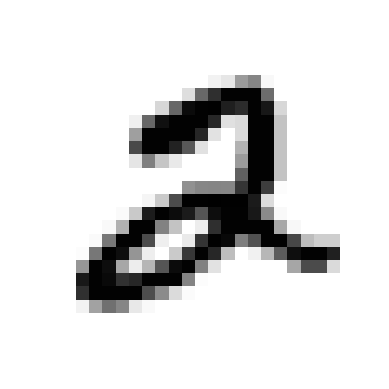

2
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0  13  25 100 122   7   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  33 151 208 252 252 252 146   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  40 152 244 252 253 224 211 252 232
  40   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  15
 152 239 252 252 252 216  31  37 252 252  60   0 

In [6]:
some_digit = X.iloc[5]
some_digit_image = some_digit.values.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

print(y.iloc[5])
print(X.iloc[5].values)

In [7]:
print(y_train.value_counts().sort_index())

0    1001
1    1127
2     991
3    1032
4     980
5     863
6    1014
7    1070
8     944
9     978
Name: class, dtype: int64


In [8]:
X_train.describe()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.0,10000.0,10000.0,10000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.198500,0.101000,0.056700,0.034500,0.033700,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.933449,3.710441,3.319004,2.087282,2.048557,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,187.000000,154.000000,0.0,0.0,0.0,0.0,0.0


In [9]:
if not X_train.isna().any().any():
    print('No missing values found')
else: print ('Handle missing values')

No missing values found


## Data Preparation and modeling

 I chose models: SVC, RandomForest, GradientBoostingClassifier and (Hard)VotingClassifier: SVC, RF, GBC

In [10]:
std_scaler = StandardScaler()

X_train = std_scaler.fit_transform(X_train)
X_val = std_scaler.transform(X_val)
X_train_test= std_scaler.fit_transform(X_train_test)
X_test= std_scaler.transform(X_test)

In [11]:
svc = SVC(random_state=42)

param_grid_svc = {'C':[0.5, 1, 1.5],
              'kernel':['linear', 'poly', 'rbf'],
             'gamma':['scale', 'auto', 1, 2]}

grid_svc = GridSearchCV(svc, param_grid = param_grid_svc, cv=3, n_jobs=-1)

grid_svc.fit(X_train, y_train)

y_pred_svc = grid_svc.predict(X_val)

Validation accuracy: 0.9605
Best parameters: {'C': 0.5, 'gamma': 1, 'kernel': 'poly'}


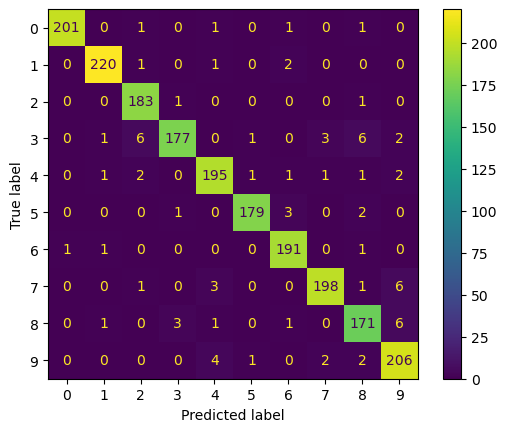

In [12]:
print("Validation accuracy:", accuracy_score(y_val, y_pred_svc))

print("Best parameters:", grid_svc.best_params_)

display_confusion_matrix(y_val, y_pred_svc)

In [13]:
rf_clf = RandomForestClassifier(random_state=42)

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(rf_clf, param_grid = param_grid_rf, cv=3, n_jobs=-2)

rf_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-2,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

Validation accuracy: 0.9565
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


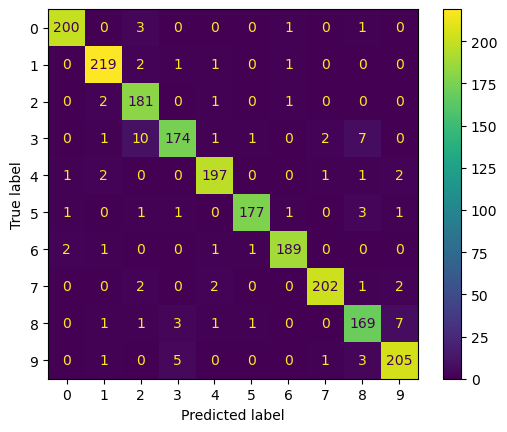

In [14]:
y_pred_rf = rf_grid.predict(X_val)

print("Validation accuracy:", accuracy_score(y_val, y_pred_rf))

print("Best parameters:", rf_grid.best_params_)

display_confusion_matrix(y_val, y_pred_rf)

In [15]:
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

In [16]:
gb_clf.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

Validation accuracy: 0.9325


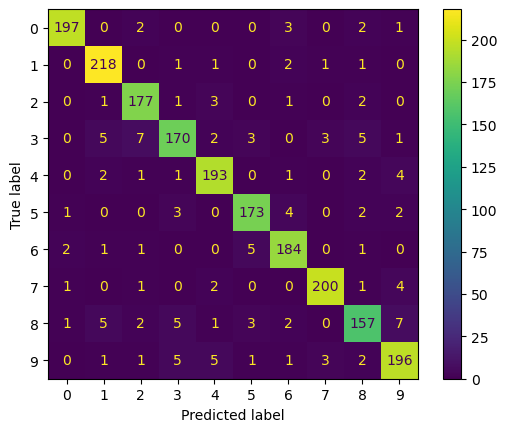

In [17]:
y_pred_gb = gb_clf.predict(X_val)

print("Validation accuracy:", accuracy_score(y_val, y_pred_gb))

display_confusion_matrix(y_val, y_pred_gb)

In [18]:
ensemble_clf = VotingClassifier(estimators=[('rf', rf_grid), ('svc', grid_svc), ('gb', gb_clf)], voting='hard', n_jobs=-1)

ensemble_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              GridSearchCV(cv=3,
                                           estimator=RandomForestClassifier(random_state=42),
                                           n_jobs=-2,
                                           param_grid={'max_depth': [None, 10,
                                                                     20, 30],
                                                       'min_samples_leaf': [1,
                                                                            2,
                                                                            4],
                                                       'min_samples_split': [2,
                                                                             5,
                                                                             10],
                                                       'n_estimators': [50, 100,
                                                                        200]})),
                             ('svc',
                              GridSearchCV(cv=3, estimator=SVC(random_state=42),
                                           n_jobs=-1,
                                           param_grid={'C': [0.5, 1, 1.5],
                                                       'gamma': ['scale',
                                                                 'auto', 1, 2],
                                                       'kernel': ['linear',
                                                                  'poly',
                                                                  'rbf']})),
                             ('gb',
                              GradientBoostingClassifier(random_state=42))],
                 n_jobs=-1)

Validation accuracy: 0.959


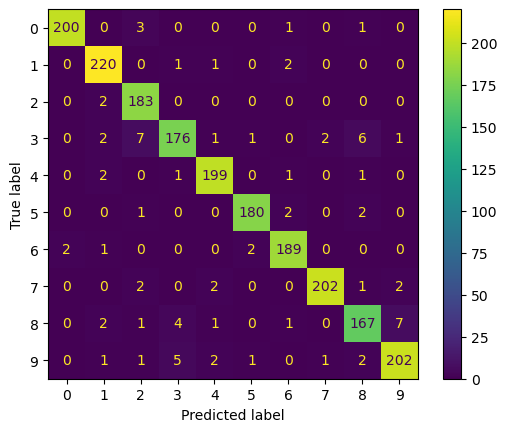

In [19]:
y_pred_vc = ensemble_clf.predict(X_val)

print("Validation accuracy:", accuracy_score(y_val, y_pred_vc))

display_confusion_matrix(y_val, y_pred_vc)

### Support Vector Machine 

That was the model that persormed best (highest accuracy). Now let's see if it's gonna perform good even om test-data.

Validation accuracy: 0.9625


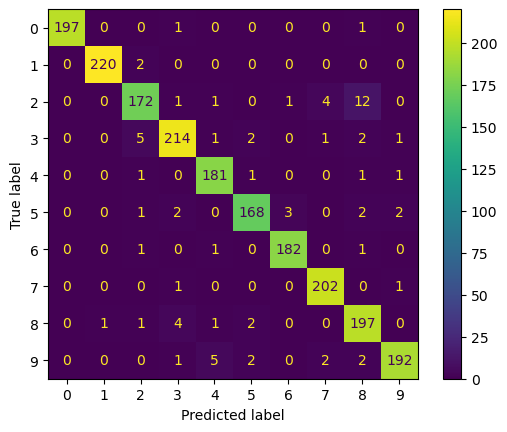

In [20]:
best_svc = SVC(C=0.5, gamma= 1, kernel='poly').fit(X_train_test, y_train_test)
y_pred_test = best_svc.predict(X_test)

print("Validation accuracy:", accuracy_score(y_test, y_pred_test))

display_confusion_matrix(y_test, y_pred_test)

# Modeling and Predictions

In [21]:
X = std_scaler.fit_transform(X.values)

In [22]:
svc_best = SVC(random_state=42, C=0.5, gamma=1, kernel='poly')

In [23]:
svc_best.fit(X, y)

SVC(C=0.5, gamma=1, kernel='poly', random_state=42)

### Image preprocessing

In [24]:
def img_preprocessing(image_path):
    
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    
    resized_image = cv2.resize(gray_image, (28, 28))

    
    normalized_image = resized_image / 255.0
    inverted_image = (1 - normalized_image) * 255.0
    
    mean_pixel_value = np.mean(inverted_image)
    inverted_image[inverted_image <= mean_pixel_value] = 0

    
    flattened_image = inverted_image.flatten()
    
    flattened_image = std_scaler.transform(flattened_image.reshape(1,-1)).flatten()

    return flattened_image.reshape(1,-1) , gray_image


### Modeling

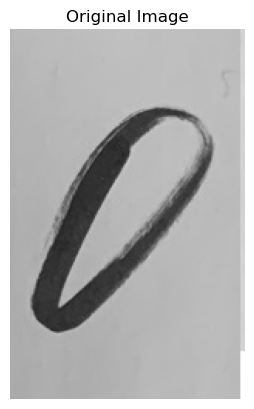

Prediction: ['0']



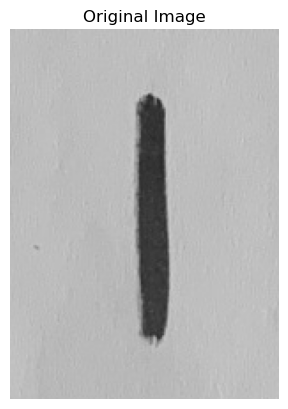

Prediction: ['1']



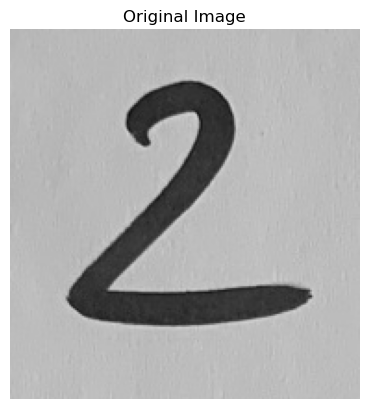

Prediction: ['2']



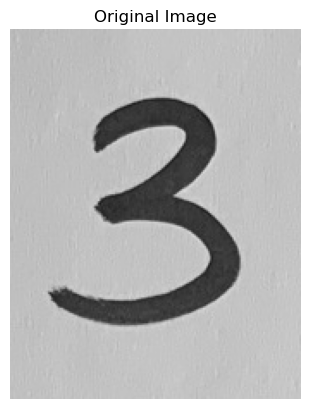

Prediction: ['3']



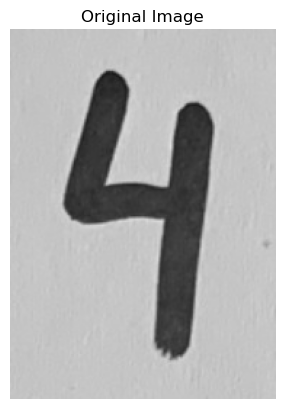

Prediction: ['4']



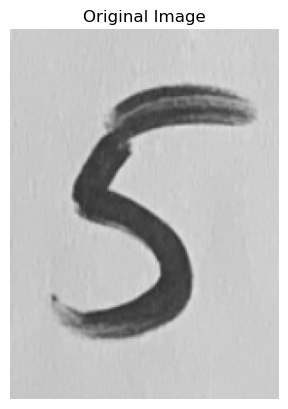

Prediction: ['5']



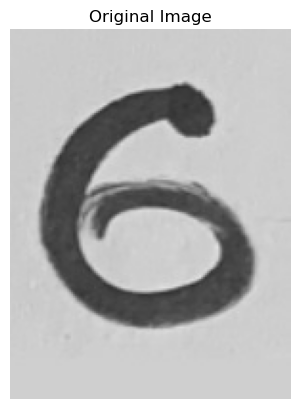

Prediction: ['5']



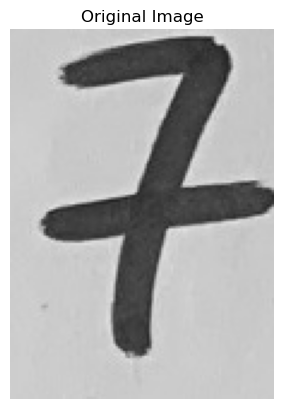

Prediction: ['7']



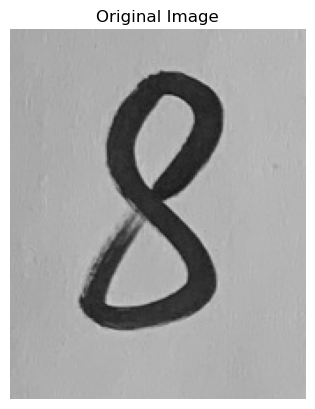

Prediction: ['8']



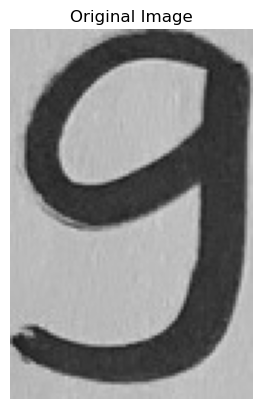

Prediction: ['9']



In [51]:
def print_image(image): 
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    plt.show()

for n in ['0_0','1_1','2','3','4','5_5','6_6','7','8','9']:
    image_path = r"C:\Users\user\OneDrive\Skrivbord\siffror\\" + n + ".jpg" 
    preprocessed_image, original_image = img_preprocessing(image_path)
    print_image(original_image)
    print('Prediction:', svc_best.predict(preprocessed_image))
    print() 